##Imports

In [ ]:
!pip install transformers torch pandas scikit-learn tqdm
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

##Google Drive for Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir("/content/drive/My Drive/yelp_review_fine-grained_5_classes_csv"))  #Change to your own path or own method for dataset

['test.csv', 'readme.txt', 'train.csv']


##Dataset

In [ ]:
print(torch.cuda.is_available())  # Should return True if GPU is available

True


In [ ]:
# Load train and test datasets
train_data = pd.read_csv("/content/drive/My Drive/yelp_review_fine-grained_5_classes_csv/train.csv")
test_data = pd.read_csv("/content/drive/My Drive/yelp_review_fine-grained_5_classes_csv/test.csv")

# Rename columns for clarity
train_data.rename(columns={"class_index": "rating", "review_text": "review"}, inplace=True)
test_data.rename(columns={"class_index": "rating", "review_text": "review"}, inplace=True)

print("Train data preview:")
print(train_data.head())

print("Test data preview:")
print(test_data.head())



Train data preview:
   rating                                             review
0       5  dr. goldberg offers everything i look for in a...
1       2  Unfortunately, the frustration of being Dr. Go...
2       4  Been going to Dr. Goldberg for over 10 years. ...
3       4  Got a letter in the mail last week that said D...
4       1  I don't know what Dr. Goldberg was like before...
Test data preview:
   rating                                             review
0       1  I got 'new' tires from them and within two wee...
1       1  Don't waste your time.  We had two different p...
2       1  All I can say is the worst! We were the only 2...
3       1  I have been to this restaurant twice and was d...
4       1  Food was NOT GOOD at all! My husband & I ate h...


In [ ]:
# Split train_data into temporary train and validation datasets
train_data_temp, val_subset = train_test_split(
    train_data, test_size=10000, stratify=train_data['rating'], random_state=42
)

# Split train_data_temp into train_subset
train_subset, _ = train_test_split(
    train_data_temp, train_size=50000, stratify=train_data_temp['rating'], random_state=42
)

# Split test_data into test_subset
test_subset, _ = train_test_split(
    test_data, train_size=10000, stratify=test_data['rating'], random_state=42
)

# Subtract 1 to ensure labels are in the range [0, 4]
train_subset['rating'] = train_subset['rating'] - 1
test_subset['rating'] = test_subset['rating'] - 1
val_subset['rating'] = val_subset['rating'] - 1

#set the classes as int
train_subset['rating'] = train_subset['rating'].astype(int)
test_subset['rating'] = test_subset['rating'].astype(int)
val_subset['rating'] = val_subset['rating'].astype(int)

#reset index
train_subset.reset_index(drop=True, inplace=True)
test_subset.reset_index(drop=True, inplace=True)
val_subset.reset_index(drop=True, inplace=True)

# Print the class distribution for each subset
print("Train Subset Class Distribution:")
print(train_subset['rating'].value_counts())

print("\nValidation Subset Class Distribution:")
print(val_subset['rating'].value_counts())

print("\nTest Subset Class Distribution:")
print(test_subset['rating'].value_counts())

# Print the shapes of the datasets
print("\nTrain Subset Shape:", train_subset.shape)
print("Validation Subset Shape:", val_subset.shape)
print("Test Subset Shape:", test_subset.shape)

Train Subset Class Distribution:
rating
2    10000
3    10000
4    10000
1    10000
0    10000
Name: count, dtype: int64

Validation Subset Class Distribution:
rating
4    2000
0    2000
1    2000
2    2000
3    2000
Name: count, dtype: int64

Test Subset Class Distribution:
rating
0    2000
4    2000
2    2000
1    2000
3    2000
Name: count, dtype: int64

Train Subset Shape: (50000, 2)
Validation Subset Shape: (10000, 2)
Test Subset Shape: (10000, 2)


###Dataset visualization

<ipython-input-11-078d7aaa9fd5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=train_subset, palette="Set2", ax=axes[0])
<ipython-input-11-078d7aaa9fd5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=val_subset, palette="Set2", ax=axes[1])
<ipython-input-11-078d7aaa9fd5>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=test_subset, palette="Set2", ax=axes[2])


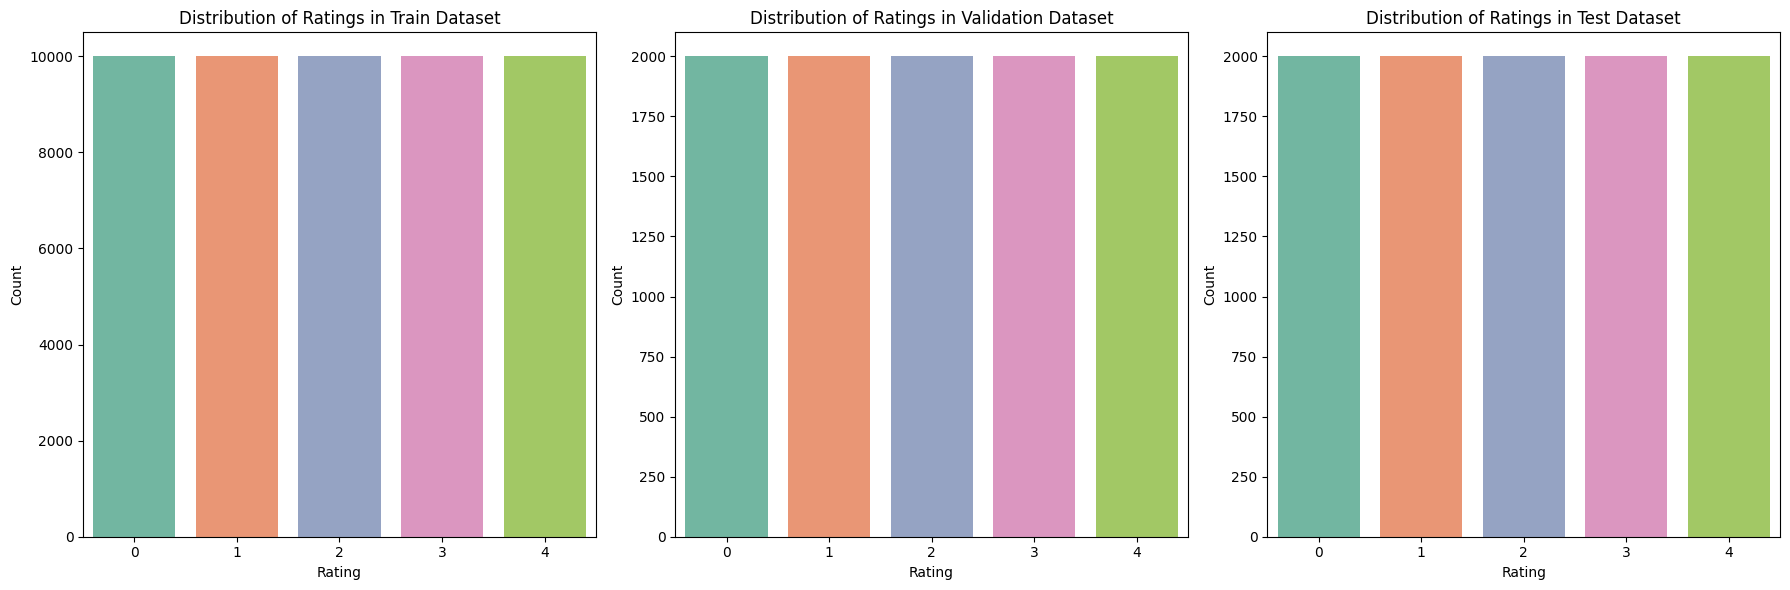

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the distribution of ratings in the train dataset
sns.countplot(x="rating", data=train_subset, palette="Set2", ax=axes[0])
axes[0].set_title("Distribution of Ratings in Train Dataset")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Count")

# Plot the distribution of ratings in the validation dataset
sns.countplot(x="rating", data=val_subset, palette="Set2", ax=axes[1])
axes[1].set_title("Distribution of Ratings in Validation Dataset")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Count")

# Plot the distribution of ratings in the test dataset
sns.countplot(x="rating", data=test_subset, palette="Set2", ax=axes[2])
axes[2].set_title("Distribution of Ratings in Test Dataset")
axes[2].set_xlabel("Rating")
axes[2].set_ylabel("Count")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


<ipython-input-12-bd3edbc519d0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="rating", y="review_length", data=train_data, palette="Set2", ax=axes[0])
<ipython-input-12-bd3edbc519d0>:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=train_data, x="review_length", kde=True, ax=axes[1], palette="Set2")


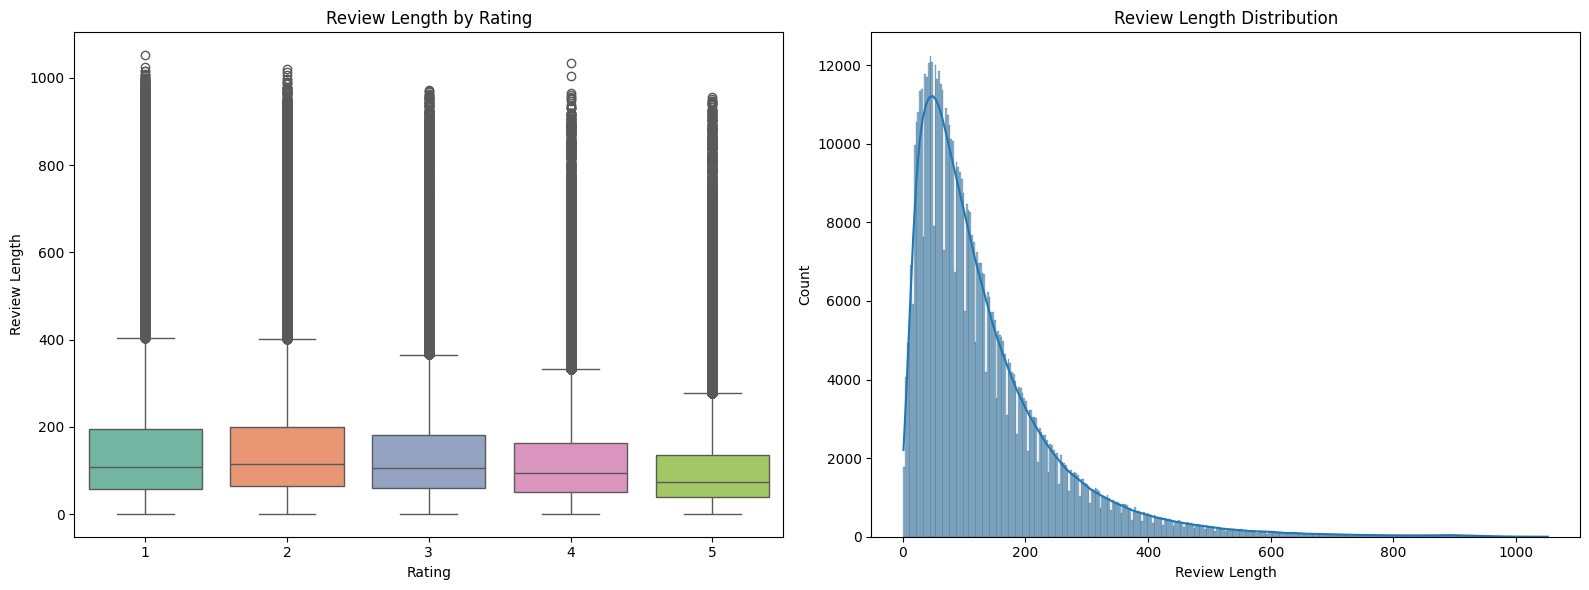

In [ ]:
# Add a column for the length of the reviews
train_data['review_length'] = train_data['review'].apply(lambda x: len(x.split()))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot: Review length by rating
sns.boxplot(x="rating", y="review_length", data=train_data, palette="Set2", ax=axes[0])
axes[0].set_title("Review Length by Rating")
axes[0].set_xlabel("Rating")
axes[0].set_ylabel("Review Length")

# Histogram: Distribution of review length
sns.histplot(data=train_data, x="review_length", kde=True, ax=axes[1], palette="Set2")
axes[1].set_title("Review Length Distribution")
axes[1].set_xlabel("Review Length")
axes[1].set_ylabel("Count")

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


###Dataset visualization "Word counts"

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from collections import Counter

customlist = ["like", "got" , "just" , "time"]
# Function to clean and preprocess the text (removing punctuation and stopwords)
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    words = text.split()
    return [word for word in words if word not in ENGLISH_STOP_WORDS and word not in customlist]

# Create cleaned_train_set and cleaned_test_set DataFrames
cleaned_train_set = train_subset.copy()  # Create a copy of train_subset
cleaned_test_set = test_subset.copy()  # Create a copy of test_subset

# Apply text cleaning to both the train and test subsets
cleaned_train_set['cleaned_review'] = train_subset['review'].apply(clean_text)
cleaned_test_set['cleaned_review'] = test_subset['review'].apply(clean_text)

# Function to get the top 10 most common words for each rating/class
def get_top_10_words(rating_class, df):
    class_texts = df[df['rating'] == rating_class]['cleaned_review']
    all_words = [word for text in class_texts for word in text]
    word_counts = Counter(all_words)
    return word_counts.most_common(10)

# Get top 10 words for each class (ratings 1 to 5)
top_10_words_per_class = {}
for class_num in range(0, 5):
    top_10_words_per_class[class_num] = get_top_10_words(class_num, cleaned_train_set) # changed train_subset to cleaned_train_set

# Display the results for each class
for class_num, top_words in top_10_words_per_class.items():
    print(f"Top 10 words for rating {class_num}:")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

Top 10 words for rating 0:
food: 5717
place: 5521
service: 4509
said: 3528
dont: 3418
good: 3218
told: 3194
didnt: 3136
did: 2723
asked: 2691

Top 10 words for rating 1:
food: 7727
place: 6121
good: 6010
service: 4186
really: 3925
dont: 3220
didnt: 3099
ordered: 2910
great: 2523
came: 2495

Top 10 words for rating 2:
good: 8179
food: 6405
place: 5905
really: 3928
service: 3374
great: 3331
pretty: 2874
nice: 2807
dont: 2641
little: 2491

Top 10 words for rating 3:
good: 7398
place: 5765
great: 5363
food: 5218
really: 3346
service: 2807
nice: 2693
little: 2406
pretty: 2039
love: 1993

Top 10 words for rating 4:
great: 5596
place: 5095
food: 4335
good: 3993
service: 2880
best: 2776
love: 2610
really: 2329
ive: 1912
amazing: 1906



Top 20 most common words in all reviews:
food: 29402
good: 28798
place: 28407
great: 18110
service: 17756
really: 15850
dont: 12807
didnt: 11001
im: 10325
nice: 10302
ordered: 9949
did: 9276
came: 9140
people: 9118
order: 8976
little: 8935
went: 8923
restaurant: 8758
pretty: 8584
ive: 8162


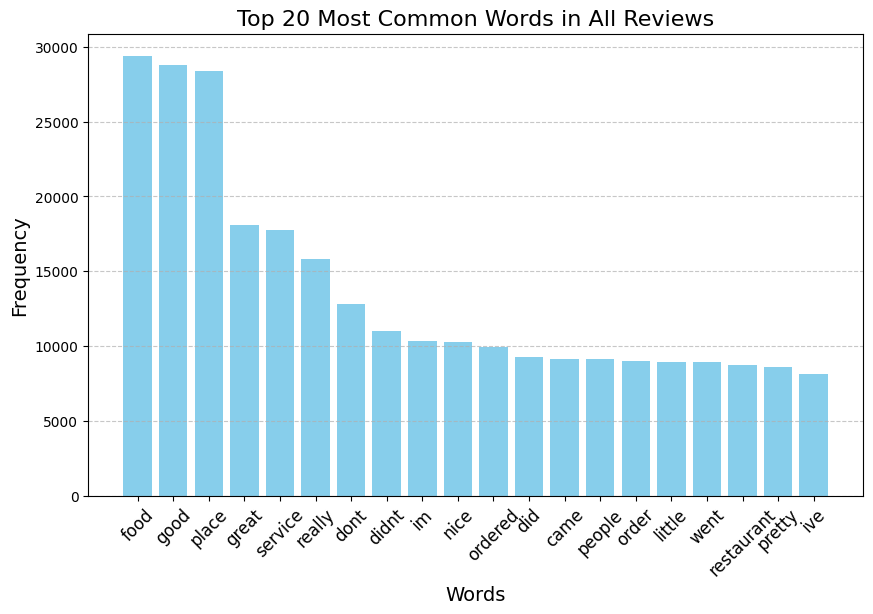

In [ ]:
# Combine all reviews into a single list of words
all_words = [word for text in cleaned_train_set['cleaned_review'] for word in text]

# Get the counts of all words
word_counts = Counter(all_words)

# Get the top 20 most common words
top_20_words = word_counts.most_common(20)

# Print the top 20 words
print("Top 20 most common words in all reviews:")
for word, count in top_20_words:
    print(f"{word}: {count}")

# Visualization
# Extract words and their counts for plotting
words = [word for word, count in top_20_words]
counts = [count for word, count in top_20_words]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title("Top 20 Most Common Words in All Reviews", fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
